In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import zarr
from load_data_for_analysis import *
from sklearn.metrics import average_precision_score, roc_auc_score

In [2]:
data_dir = "/data/mikulik/PolarbearPlus/notebooks/data/"

In [4]:
snareseq_barcodes, snareseq_peaks, gene_names = load_snare_data(os.path.join(data_dir, "snareseq"))
true_split = get_test_split_index(os.path.join(data_dir, "split"))
test_cell_names = get_celltype_annotations(
    os.path.join(data_dir, "diffexp"), snareseq_barcodes=snareseq_barcodes, true_split=true_split
)

diff_genes = load_diff_genes(os.path.join(data_dir, "diffexp"))
diff_genes_ind = get_diff_gene_ind(gene_names, diff_genes)

rna_counts, obs_rna = get_rna_counts(os.path.join(data_dir, "snareseq/"), true_split)
atac_counts, obs_atac = get_atac_counts(os.path.join(data_dir, "snareseq/"), true_split)

diff_peaks_ind = get_diff_peaks_ind(os.path.join(data_dir, "diffexp"), snareseq_peaks)

# Sparsity of the dataset

In [5]:
# RNA
print(f"Percentage of zeros in RNA data: {rna_counts[rna_counts != 0].shape[0] / rna_counts.flatten().shape[0]}")
diff_tmp = rna_counts[:, diff_genes_ind]
print(
    f"Percentage of zeros in RNA data of only differentially expressed genes: {diff_tmp[diff_tmp != 0].shape[0] / diff_tmp.flatten().shape[0]}"
)

# ATAC
print(f"Percentage of zeros in ATAC data: {atac_counts[atac_counts != 0].shape[0] / atac_counts.flatten().shape[0]}")
diff_tmp = atac_counts[:, diff_peaks_ind]
print(
    f"Percentage of zeros in ATAC data of only differentially expressed genes: {diff_tmp[diff_tmp != 0].shape[0] / diff_tmp.flatten().shape[0]}"
)

Percentage of zeros in RNA data: 0.04907542283040635
Percentage of zeros in RNA data of only differentially expressed genes: 0.26181624176580043
Percentage of zeros in ATAC data: 0.008987675164910662
Percentage of zeros in ATAC data of only differentially expressed genes: 0.005093140321941734


# AUROC

In [6]:
def get_reconstructed_counts(zarr_file):
    zarr_file = os.path.join(zarr_file, "prediction/stats.zarr")
    a = zarr.open(zarr_file, mode="r")
    return a["reconstruction_stats"]["mean"], a["reconstruction_stats"]["var"]


def get_reconstructed_cross_modality(zarr_file):
    zarr_file = os.path.join(zarr_file, "prediction/stats.zarr")
    a = zarr.load(zarr_file)
    return a["mean"], a["var"]

In [7]:
# ATACVAE predictions
mean_pred_atac, var_pred_atac = get_reconstructed_counts("/data/mikulik/mnt_polarbear_exp/atacvae/settings_polarbear")
mean_pred_atac, var_pred_atac = (
    torch.from_numpy(np.asarray(mean_pred_atac)),
    torch.from_numpy(np.asarray(var_pred_atac)),
)

# MLP Translator RNA2ATAC
mean_pred_mlp_atac, var_pred_mlp_atac = get_reconstructed_cross_modality(
    "/data/mikulik/mnt_polarbear_exp/mlptranslator/settings_polarbear_rna2atac"
)
# print(mean_pred_mlp_atac.shape)

In [8]:
def compute_per_peak_auroc(obs, pred, diff_peaks_ind):
    # keep only the differentially accessible peaks
    obs = obs[:, diff_peaks_ind]
    pred = pred[:, diff_peaks_ind]

    # remove all peaks for which test set observed counts are all zero counts
    pred = pred[:, obs.sum(axis=0) != 0]
    obs = obs[:, obs.sum(axis=0) != 0]

    n_peaks = obs.shape[1]
    all_peaks = []
    for peak in range(n_peaks):
        all_peaks.append(roc_auc_score(obs[:, peak], pred[:, peak]))
    return all_peaks


def compute_aupr_norm(obs, pred):
    x = average_precision_score(obs, pred)
    pp = np.sum(obs)  # number of cells with peak accessible
    pp = pp / obs.shape[0]  # number of all cells
    aupr_norm = (x - pp) / (1 - pp)
    return aupr_norm


def compute_per_peak_aupr_norm(obs, pred, diff_peaks_ind):
    # keep only the differentially accessible peaks
    obs = obs[:, diff_peaks_ind]
    pred = pred[:, diff_peaks_ind]

    # remove all peaks for which test set observed counts are all zero counts
    pred = pred[:, obs.sum(axis=0) != 0]
    obs = obs[:, obs.sum(axis=0) != 0]

    n_peaks = obs.shape[1]
    all_peaks = []
    for peak in range(n_peaks):
        aupr_norm = compute_aupr_norm(obs[:, peak], pred[:, peak])
        all_peaks.append(aupr_norm)
    return all_peaks

In [9]:
per_peak_auroc_dict, per_peak_aupr_list = {}, {}

# Read in translations
latent_inn, _ = get_reconstructed_cross_modality("/data/mikulik/mnt_polarbear_exp/inntranslator/latent_rna2atac_v1/")
sample_inn, _ = get_reconstructed_cross_modality("/data/mikulik/mnt_polarbear_exp/inntranslator/sample_rna2atac_v1/")
double_sample, _ = get_reconstructed_cross_modality(
    "/data/mikulik/mnt_polarbear_exp/inntranslator/doublesample_rna2atac_v1"
)
mean_pred_mlp_rna, var_pred_mlp_rna = get_reconstructed_cross_modality(
    "/data/mikulik/mnt_polarbear_exp/mlptranslator/settings_polarbear_rna2atac/"
)
mean_pred_mlp_rna_sane, var_pred_mlp_rna_sane = get_reconstructed_cross_modality(
    "/data/mikulik/mnt_polarbear_exp/mlptranslator/settings_sane_rna2atac/"
)

for reconstruction, name in zip(
    [mean_pred_mlp_rna, mean_pred_mlp_rna_sane, latent_inn, sample_inn, double_sample],
    ["mlp_sample", "mlp_latent", "latent_inn", "sample_inn", "double_sample_inn"],
    strict=False,
):
    # compute per peak AUROC
    per_peak_auroc = compute_per_peak_auroc(obs_atac, reconstruction, diff_peaks_ind)
    per_peak_auroc_dict[name] = per_peak_auroc

    # compute per peak normalized AUPR
    per_peak_aupr_norm = compute_per_peak_aupr_norm(obs_atac, reconstruction, diff_peaks_ind)
    per_peak_aupr_list[name] = per_peak_aupr_norm

In [10]:
def compare_correlations(x, y, title="", x_label="", y_label="", save_fig=False, file_name="corr.pdf"):
    sns.scatterplot(x=x, y=y, s=8, c="black")
    plt.title(title, fontsize=25)
    sns.lineplot(x=x, y=x, c="black")
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel(f"{y_label}, mean:{np.asarray(y).mean():.3f}", fontsize=15)
    plt.xlabel(f"{x_label}, mean: {np.asarray(x).mean():.3f}", fontsize=15)
    sns.kdeplot(x=x, y=y, fill=True, alpha=0.7, cmap="Blues")
    if save_fig is not None:
        plt.savefig(os.path.join(save_fig, file_name))
    plt.show()


save_figs = "/data/mikulik/PolarbearPlus/notebooks/figures"

In [11]:
len(diff_peaks_ind)

67328

In [12]:
7734 + 4455

12189

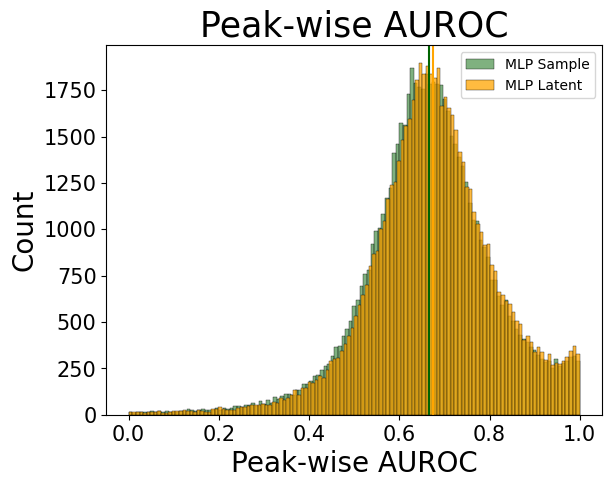

In [13]:
sns.histplot(per_peak_auroc_dict["mlp_sample"], label="MLP Sample", color="darkgreen", alpha=0.5)
plt.axvline(np.asarray(per_peak_auroc_dict["mlp_sample"]).mean(), c="darkgreen")
sns.histplot(per_peak_auroc_dict["mlp_latent"], label="MLP Latent", color="orange")
plt.axvline(np.asarray(per_peak_auroc_dict["mlp_latent"]).mean(), c="orange")
plt.title("Peak-wise AUROC", fontsize=25)
# sns.lineplot(x=x, y=x, c="black")
plt.ylabel("Count", fontsize=20)
plt.xlabel("Peak-wise AUROC", fontsize=20)
plt.xticks(fontsize=15)  # , rotation=90)
plt.yticks(fontsize=15)  # , rotation=90)
plt.legend()
plt.savefig(os.path.join(save_figs, "hist_auroc_mlp.pdf"))
plt.show()

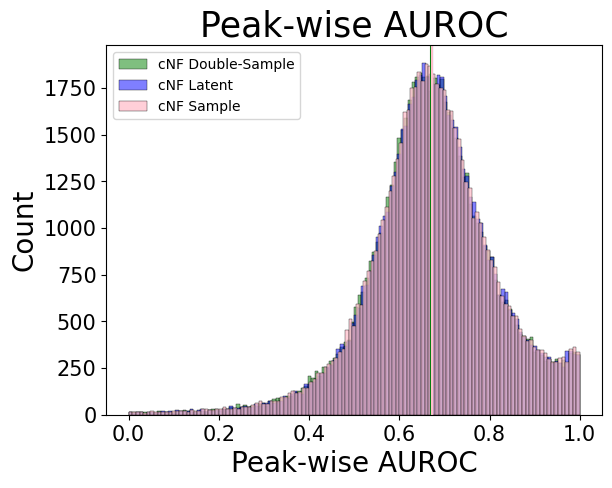

In [14]:
sns.histplot(per_peak_auroc_dict["double_sample_inn"], label="cNF Double-Sample", color="green", alpha=0.5)
plt.axvline(np.asarray(per_peak_auroc_dict["double_sample_inn"]).mean(), c="green")
sns.histplot(per_peak_auroc_dict["latent_inn"], label="cNF Latent", color="blue", alpha=0.5)
plt.axvline(np.asarray(per_peak_auroc_dict["latent_inn"]).mean(), c="blue")
sns.histplot(per_peak_auroc_dict["sample_inn"], label="cNF Sample", color="pink")
plt.axvline(np.asarray(per_peak_auroc_dict["sample_inn"]).mean(), c="pink")
plt.title("Peak-wise AUROC", fontsize=25)
# sns.lineplot(x=x, y=x, c="black")
plt.ylabel("Count", fontsize=20)
plt.xlabel("Peak-wise AUROC", fontsize=20)
plt.yticks(fontsize=15)  # , rotation=90)
plt.xticks(fontsize=15)  # , rotation=90)
plt.legend()
plt.savefig(os.path.join(save_figs, "hist_auroc_cNF.pdf"))
plt.show()
# plt.tick_params(axis='both', which='major', labelsize=15)
# plt.tick_params(axis='both', which='major', labelsize=10)
# sns.kdeplot(x=x, y=y, fill=True, alpha=0.7, cmap="Blues")

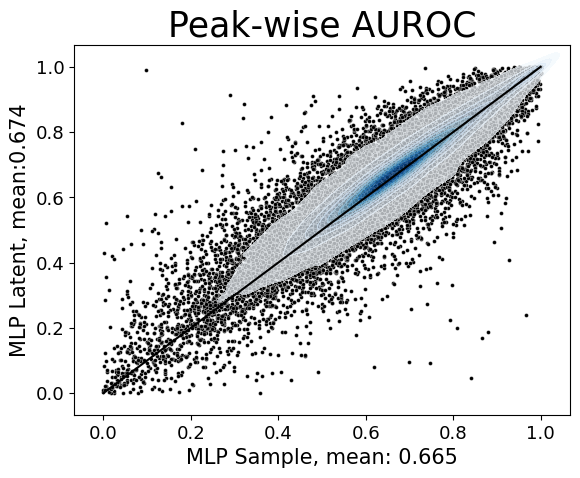

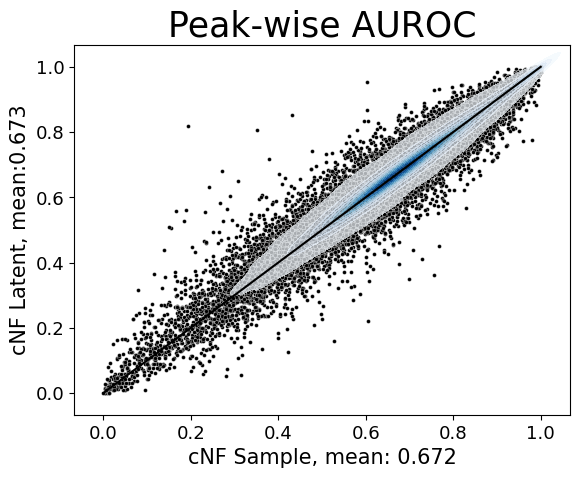

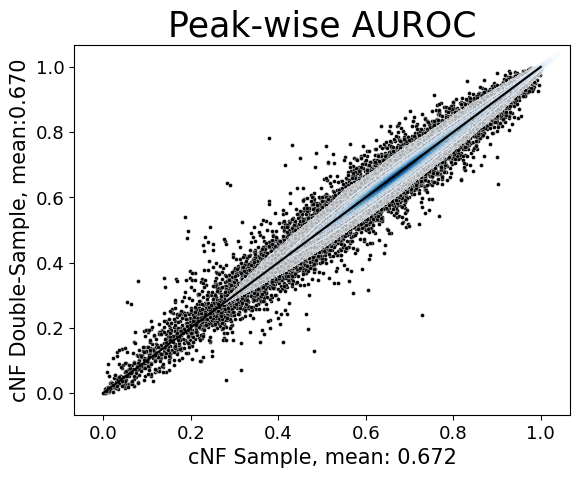

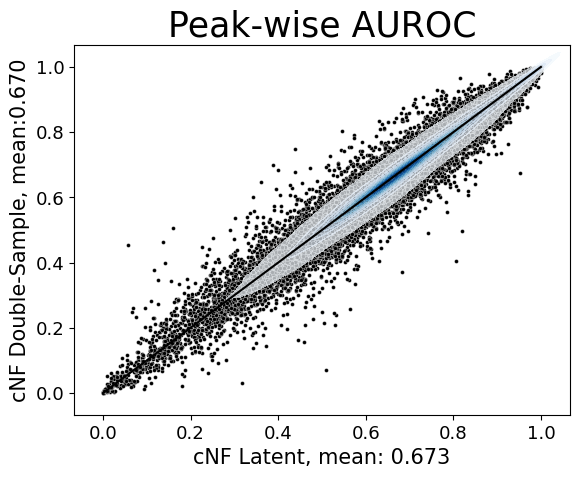

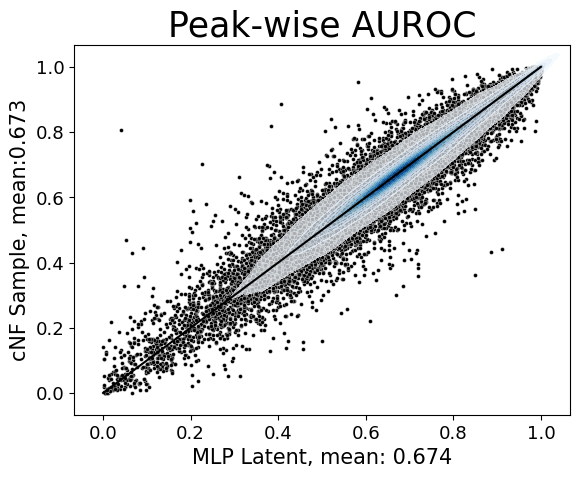

In [15]:
compare_correlations(
    x=per_peak_auroc_dict["mlp_sample"],
    y=per_peak_auroc_dict["mlp_latent"],
    title="Peak-wise AUROC",
    x_label="MLP Sample",
    y_label="MLP Latent",
    save_fig=save_figs,
    file_name="auroc_mlp_latent_sample.pdf",
)
compare_correlations(
    x=per_peak_auroc_dict["sample_inn"],
    y=per_peak_auroc_dict["latent_inn"],
    title="Peak-wise AUROC",
    x_label="cNF Sample",
    y_label="cNF Latent",
    save_fig=save_figs,
    file_name="auroc_cNF_latent_sample.pdf",
)
compare_correlations(
    x=per_peak_auroc_dict["sample_inn"],
    y=per_peak_auroc_dict["double_sample_inn"],
    title="Peak-wise AUROC",
    x_label="cNF Sample",
    y_label="cNF Double-Sample",
    save_fig=save_figs,
    file_name="auroc_cNF_sample_doublesample.pdf",
)
compare_correlations(
    x=per_peak_auroc_dict["latent_inn"],
    y=per_peak_auroc_dict["double_sample_inn"],
    title="Peak-wise AUROC",
    x_label="cNF Latent",
    y_label="cNF Double-Sample",
    save_fig=save_figs,
    file_name="auroc_cNF_latent_doublesample.pdf",
)
compare_correlations(
    x=per_peak_auroc_dict["mlp_latent"],
    y=per_peak_auroc_dict["latent_inn"],
    title="Peak-wise AUROC",
    x_label="MLP Latent",
    y_label="cNF Sample",
    save_fig=save_figs,
    file_name="auroc_mlp_latent_cNF_sample.pdf",
)

In [17]:
# for mlp, mlp_name in zip(["mlp_sample", "mlp_latent"], ["MLP Sample", "MLP Latent"]):
#    #compare_correlations(x=per_peak_auroc_dict[mlp], y=per_peak_auroc_dict["latent_inn"], title=f"peak-wise AUROC", x_label=mlp_name, y_label="Latent INN")
#    #compare_correlations(x=per_peak_auroc_dict[mlp], y=per_peak_auroc_dict["sample_inn"], title=f"peak-wise AUROC", x_label=mlp_name, y_label="Sample INN")
#    #compare_correlations(x=per_peak_auroc_dict[mlp], y=per_peak_auroc_dict["double_sample_inn"], title=f"peak-wise AUROC", x_label=mlp_name, y_label="Double Sample INN")
#
#    compare_correlations(x=per_peak_aupr_list[mlp], y=per_peak_aupr_list["latent_inn"], title=f"peak-wise AUPRnorm", x_label=mlp_name, y_label="Latent INN")
#    compare_correlations(x=per_peak_aupr_list[mlp], y=per_peak_aupr_list["sample_inn"], title=f"peak-wise AUPRnorm", x_label=mlp_name, y_label="Sample INN")
#    compare_correlations(x=per_peak_aupr_list[mlp], y=per_peak_aupr_list["double_sample_inn"], title=f"peak-wise AUPRnorm", x_label=mlp_name, y_label="Double Sample INN")